#### ENTER ACCESS_KEY AND SECRET KEY

In [83]:
Access_Key = "LMWLG31WZS"
Secret_Key = "jxAvgFWSoZmFdlTpmKCv"

#### ENTER PIPELINE NUMBER, SOURCE PASSWORD, DESTINATION PASSWORD

In [84]:
pipeline_number = 1314
source_password = 'root'
destination_password = 'demoDEMO1236'

### Get Pipeline API call

In [85]:
import requests
import base64

  
sample_string = (Access_Key)+":"+(Secret_Key)
sample_string_bytes = sample_string.encode("ascii")
  
base64_bytes = base64.b64encode(sample_string_bytes)
base64_string = base64_bytes.decode("ascii")
  
#print(f"Encoded string: {base64_string}")

url = 'https://us.hevodata.com/api/public/v2.0/pipelines/'+ str(pipeline_number)
headers = {'Accept':'application/json','Authorization': 'Basic '+ base64_string}
r = requests.get(url, headers=headers)

#print (r.json())
#print (r.json()['data']['destination'])

### Initialize Source connection

In [86]:
import great_expectations as ge
#import psycopg2 
import pymysql
import mysql.connector as mysql
import pandas as pd

if r.json()['data']['source']['type']['name']=='MYSQL':
    user = r.json()['data']['source']['config']['db_user']
    password = r.json()['data']['source']['config']['db_password']
    port = r.json()['data']['source']['config']['db_port']
    host = r.json()['data']['source']['config']['db_host']
    db = r.json()['data']['source']['config']['db_names']
    CONN=mysql.connect(host=str(host),user=str(user),passwd='root',db=db[0]) #case if many dbs are connected
elif r.json()['data']['source']['type']['name']=='POSTGRES':
    user = r.json()['data']['source']['config']['db_user']
    password = r.json()['data']['source']['config']['db_password']
    port = r.json()['data']['source']['config']['db_port']
    host = r.json()['data']['source']['config']['db_host']
    db = r.json()['data']['source']['config']['db_names']
    CONN=psycopg2.connect(host=host,port=port,user=user,password='root',database=db)

df = pd.read_sql_query(' SELECT * FROM Ecommerce.Products',CONN)
df.head(5)

,ID,sku,category,description,price,isActive,lastUpdated,countryOfOrigin
0,2,94-627-4318,Beverage,Automotive,641.0,0.0,2020-10-15,India
1,3,74-796-0764,Electronics,Computers,553.0,0.0,2020-12-08,India
2,4,49-352-4119,Shoes,Toys,758.0,0.0,2021-05-29,India
3,5,04-081-4946,Electronics,Grocery,335.0,1.0,2021-02-11,India
4,6,46-404-3883,Beverage,Electronics,782.0,1.0,2020-06-09,India


### Initialize Destination connection

In [87]:
import snowflake.connector
import redshift_connector
import pandas as pd

if r.json()['data']['destination']['type']['name'] == 'SNOWFLAKE':
    db_name = r.json()['data']['destination']['config']['db_name']
    db_user = r.json()['data']['destination']['config']['db_user']
    account_name = r.json()['data']['destination']['config']['account_name']
    schema_name = r.json()['data']['destination']['config']['schema_name']
    warehouse = r.json()['data']['destination']['config']['warehouse']
    region = r.json()['data']['destination']['config']['region']
    conn =  snowflake.connector.connect(user=str(db_user), password=str(destination_password), 
                                                    account=str(account_name) + "." + str(region), role='ACCOUNTADMIN', warehouse=warehouse,
                                                    database = str(db_name), schema = str(schema_name))
elif r.json()['data']['destination']['type']['name'] == 'REDSHIFT':    
    db_name = r.json()['data']['destination']['config']['db_name']
    db_host = r.json()['data']['destination']['config']['db_host']
    db_user = r.json()['data']['destination']['config']['db_user']
    db_port = r.json()['data']['destination']['config']['db_port']
    conn = redshift_connector.connect(host=str(db_host),user=str(db_user),password='demoDEMO1236'
                                 ,port=db_port,database=str(db_name))
#conn
#dff = pd.read_sql_query("Select * from demo.public.mysql_data_ecommerce_products",conn)
# dff.head(20)

/Users/nikhilbansal/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Loop through source tables

In [88]:
url = "https://us.hevodata.com/api/public/v2.0/pipelines/"+str(pipeline_number)+"/event-types?limit=100"

headers = {
    "Accept": "application/json",
    "Authorization": 'Basic '+ base64_string
}

response = requests.request("GET", url, headers=headers)

#print(response.json())
table_count = (response.json()['pagination']['count'])
source_tables = []
for i in range(table_count):
    source_tables.append(response.json()['data'][i]['event_type'])
    
print(source_tables)


['Products', 'Users', 'userAddress']


### Source Row Count

In [89]:
#df = pd.read_sql_query('show tables',db)
source_row_count={}
for table in source_tables:
        #print (column)
    source_row_count.setdefault(table,0)
#print(source_row_count)

for i in source_row_count.keys():
    dff = pd.read_sql_query("Select * from Ecommerce."+i,CONN)
    source_row_count[i]=dff.shape[0] 
source_row_count = {k.lower(): v for k,v in source_row_count.items()}
source_row_count
row_counts_1 = []
for i in source_row_count.values():
    row_counts_1.append(i)
#row_counts_1 = source_row_count.values()
row_counts_1

[504, 513, 505]

### Loop through respective destination tables

In [90]:
destination_tables=[]
for i in source_tables:
    url = "https://us.hevodata.com/api/public/v2.0/pipelines/"+str(pipeline_number)+"/mappings/" + i

    headers = {
        "Accept": "application/json",
        "Authorization": 'Basic '+ base64_string
    }

    response = requests.request("GET", url, headers=headers)
    destination_tables.append(response.json()['data']['destination_table'])
#     print(response.json()['data']['destination_table'])
#destination_tables

### Destination Row Count

In [91]:
destination_row_count={}
for table in destination_tables:
        #print (column)
    destination_row_count.setdefault(table,0)
#print(destination_row_count)
for i in destination_row_count.keys():
    dff = pd.read_sql_query("Select * from demo.public."+i,conn)
    destination_row_count[i]=dff.shape[0] 
#     print (dff.head())
#destinaton_row_count = {k.lower(): v for k,v in destination_tables.items()}
print(destination_row_count)
row_counts_2=[]
for i in destination_row_count.values():
    row_counts_2.append(i)
#row_counts_1 = source_row_count.values()
row_counts_2

# dff = pd.read_sql_query("Select * from demo.public.test1_users",conn)
# dff.head()

{'test2_products': 504, 'test2_users': 513, 'test2_useraddress': 505}


[504, 513, 505]

## Plotting

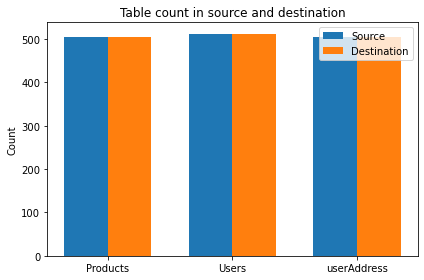

In [92]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(source_tables))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, row_counts_1, width, label='Source')
rects2 = ax.bar(x + width/2, row_counts_2, width, label='Destination')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Table count in source and destination')
ax.set_xticks(x) # values
ax.set_xticklabels(source_tables) # labels
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

### Compare Row Count of both tables

In [93]:
# data.expect_table_row_count_to_equal(df.shape[0])

### Compare Column Count

In [94]:
# data.expect_table_column_count_to_equal(df.shape[1])

### Column Values to not be NULL

In [95]:
# data.expect_column_values_to_not_be_null('ID')

### Column values to be unique

In [96]:
# data.expect_column_values_to_be_unique('ID')